Data is in the csv files saved in capstone-project1-data-wrangling.ipynb:

ice_final.csv - for ice

CO2_final.csv - for CO2

fire_M6_final.csv and fire_V1_final.csv - for fire

The M6 dataset has about 20 years of data from Terra and Aqua satellites and the V1 dataset has only 8 years of data from Suomi satellite.


Since the instruments and resolutions are different and I don't want to lose 12 years of data,
there will be two separate datasets for fire data

In [1]:
ls -ltrh ./Data/ice

total 24944
-rw-rw-rw-  1 bogdan  staff   2.2M Oct 24 11:58 N_seaice_extent_daily_v3.0.csv
-rw-rw-rw-  1 bogdan  staff   2.2M Oct 24 12:03 S_seaice_extent_daily_v3.0.csv
-rw-rw-rw-@ 1 bogdan  staff   3.2M Oct 24 12:05 Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx
-rw-r--r--@ 1 bogdan  staff   4.6M Nov 29 19:28 ice_final.csv


In [2]:
ls -ltrh ./Data/co2

total 432
-rw-r--r--@ 1 bogdan  staff    48K Nov 11 21:44 monthly_in_situ_co2.csv
-rw-r--r--@ 1 bogdan  staff    29K Nov 21 18:58 co2_mm_mlo.csv
-rw-r--r--@ 1 bogdan  staff    27K Nov 23 20:18 CO2_final.csv
-rw-r--r--@ 1 bogdan  staff    71K Nov 27 18:35 CO2_0000-2014.csv
-rw-r--r--@ 1 bogdan  staff    27K Dec  1 14:44 CO2_final_November.csv
-rw-r--r--  1 bogdan  staff   634B Dec  2 18:54 CO2_diff.csv


In [3]:
ls -ltrh ./Data/fire/*.csv

-rw-r--r--@ 1 bogdan  staff    50M Nov 24 12:56 ./Data/fire/fire_M6_final.csv
-rw-r--r--@ 1 bogdan  staff    85M Nov 24 13:03 ./Data/fire/fire_V1_final.csv


In [2]:
import numpy as np
import pandas as pd
import random
import os
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Load fire data
# I won't set the index to the date column because there are several observations for each date
# The observations are ordered by date and for the same date they are ordered by decimal_time
fire_M6=pd.read_csv('./Data/fire/fire_M6_final.csv', index_col = False)
fire_V1=pd.read_csv('./Data/fire/fire_V1_final.csv', index_col = False)

In [6]:
fire_M6.head(3)

,acq_date,frp,latitude,longitude,decimal_time,mean_brightness,low_confidence,medium_confidence,high_confidence
0,2000-11-01,26.8,-20.8650,146.3039,0.01181,317.00,True,False,False
1,2000-11-01,68.8,-20.5602,146.0194,0.01181,319.95,False,True,False
2,2000-11-01,7.1,-24.3197,151.5619,0.01250,311.15,False,True,False


In [7]:
fire_V1.head(3)

,acq_date,frp,latitude,longitude,decimal_time,mean_brightness,low_confidence,medium_confidence,high_confidence
0,2012-01-31,0.9,11.81456,4.97983,0.05208,298.45,False,True,False
1,2012-01-31,1.3,10.39675,13.45527,0.05208,302.25,False,True,False
2,2012-01-31,1.9,13.73985,13.83765,0.05208,301.80,False,True,False


In [8]:
# Load CO2 data
CO2=pd.read_csv('./Data/co2/CO2_final.csv', index_col = False)
CO2.head(3)

,Year,Month,decimal_date,CO2_ppm,trend
0,1958,3,1958.208,315.71,314.62
1,1958,4,1958.292,317.45,315.29
2,1958,5,1958.375,317.50,314.71


As shown above, there is still a problem with the dates of the observations. CO2 dataset 
has monthly observations.

Furthermore, the difference from one month to another can be signifficant, for example
there are 315.71 ppm in March 1958 and 317.45 ppm in April 1958. Therefore CO2 data 
must be interpolated daily before making any correlation with ice and fire datasets

In [9]:
# Load ice data
ice=pd.read_csv('./Data/ice/ice_final.csv', index_col = False)
ice = ice.set_index('Unnamed: 0')
ice.index.name = None
print(ice.columns)

Index(['Baffin-Area-km^2', 'Baffin-Extent-km^2', 'Barents-Area-km^2',
       'Barents-Extent-km^2', 'Beaufort-Area-km^2', 'Beaufort-Extent-km^2',
       'Bering-Area-km^2', 'Bering-Extent-km^2',
       'CanadianArchipelago-Area-km^2', 'CanadianArchipelago-Extent-km^2',
       'Central-Arctic-Area-km^2', 'Central-Arctic-Extent-km^2',
       'Chukchi-Area-km^2', 'Chukchi-Extent-km^2', 'East-Siberian-Area-km^2',
       'East-Siberian-Extent-km^2', 'Greenland-Area-km^2',
       'Greenland-Extent-km^2', 'Hudson-Area-km^2', 'Hudson-Extent-km^2',
       'Kara-Area-km^2', 'Kara-Extent-km^2', 'Laptev-Area-km^2',
       'Laptev-Extent-km^2', 'Okhotsk-Area-km^2', 'Okhotsk-Extent-km^2',
       'St-Lawrence-Area-km^2', 'St-Lawrence-Extent-km^2', 'extent_north',
       'extent_south'],
      dtype='object')


In [10]:
# use shorter names
ice.columns = ['Baffin', 'Baffin-ext', 'Barents-ext', 'Beaufort', 'Barents', 'Beaufort-ext',
'Bering', 'Bering-ext', 'Canadian', 'Canadian-ext', 'Central-Arctic', 'Central-Arctic-ext',
'Chukchi', 'Chukchi-ext', 'East-Siberian', 'East-Siberian-ext', 'Greenland', 'Greenland-ext',
'Hudson', 'Hudson-ext', 'Kara', 'Kara-ext', 'Laptev', 'Laptev-ext', 'Okhotsk', 'Okhotsk-ext',
'St-Lawrence', 'St-Lawrence-ext', 'North_ext', 'South_ext']
print(ice.columns)

Index(['Baffin', 'Baffin-ext', 'Barents-ext', 'Beaufort', 'Barents',
       'Beaufort-ext', 'Bering', 'Bering-ext', 'Canadian', 'Canadian-ext',
       'Central-Arctic', 'Central-Arctic-ext', 'Chukchi', 'Chukchi-ext',
       'East-Siberian', 'East-Siberian-ext', 'Greenland', 'Greenland-ext',
       'Hudson', 'Hudson-ext', 'Kara', 'Kara-ext', 'Laptev', 'Laptev-ext',
       'Okhotsk', 'Okhotsk-ext', 'St-Lawrence', 'St-Lawrence-ext', 'North_ext',
       'South_ext'],
      dtype='object')


In [11]:
ice.head(3)

,Baffin,Baffin-ext,Barents-ext,Beaufort,Barents,Beaufort-ext,Bering,Bering-ext,Canadian,Canadian-ext,...,Kara,Kara-ext,Laptev,Laptev-ext,Okhotsk,Okhotsk-ext,St-Lawrence,St-Lawrence-ext,North_ext,South_ext
1978-10-28,416908.720,521862.289,222781.361,361743.416,895310.805,940219.39,11472.805,35555.883,719220.320,761228.252,...,569610.622,815398.750,802884.363,872414.226,16799.581,35135.582,0.0,0.0,10.4200,17.8030
1978-10-29,416908.720,521862.289,222781.361,361743.416,895310.805,940219.39,11472.805,35555.883,719220.320,761228.252,...,569610.622,815398.750,802884.363,872414.226,16799.581,35135.582,0.0,0.0,10.4885,17.7365
1978-10-30,419829.102,531533.703,229769.256,379395.172,894088.098,940219.39,13553.099,42670.305,717303.629,761228.252,...,562328.391,816017.367,806760.991,872414.226,18745.308,39102.698,0.0,0.0,10.5570,17.6700


Exploratory Data Analysis (EDA)

There are two ideas for EDA. The datasets for fire, CO2, ice can be explored individually. After that, the datasets can be merged in one big dataset. This would simplify noticing correlations between the datasets.

EDA - CO2

For showing the data in a historical context, I am showing the data acquired from the ice cores (more than 2000 years of data). Old ice in Antarctica trapped small bubbles of air and the air composition from these bubbles can be analyzed with modern techniques.

<Figure size 432x288 with 0 Axes>

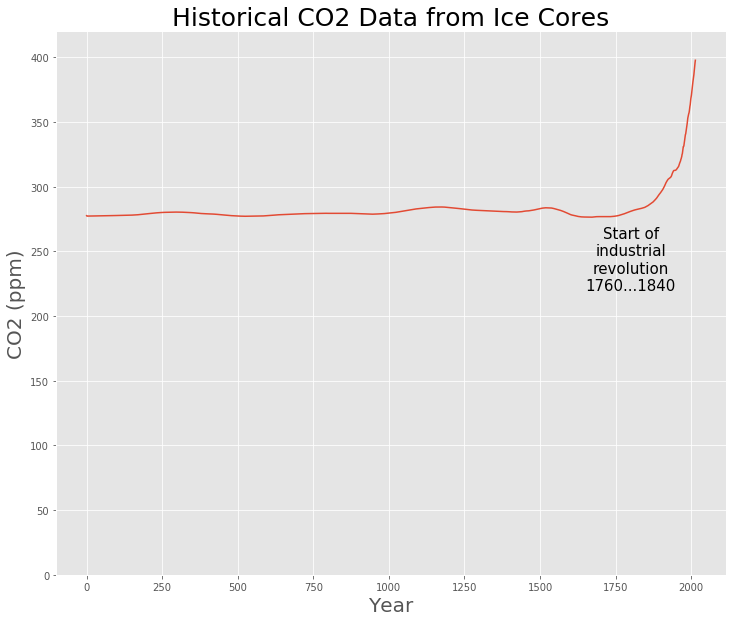

In [12]:
co2_old_df = pd.read_csv('./Data/co2/CO2_0000-2014.csv')
plt.style.use('ggplot')
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.ylim(bottom=0, top=420)
plt.plot(co2_old_df['year'], co2_old_df['data_mean_global'])
plt.text(1800, 220, 'Start of\nindustrial\nrevolution\n1760...1840', horizontalalignment='center', fontsize=15)
plt.title('Historical CO2 Data from Ice Cores', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('CO2 (ppm)', fontsize=20)
plt.show()

The data shows a significant increase in CO2 levels since the start of the industrial revolution that happened between 1760...1840 https://en.wikipedia.org/wiki/Industrial_Revolution.

The latest 5 years of data are missing from the ice cores data and during these 5 years the CO2 level reached 414 ppm.

The best known CO2 dataset is the one from Mauna Loa (NOAA data)

There is a trend and a seasonal component, as shown below

<Figure size 432x288 with 0 Axes>

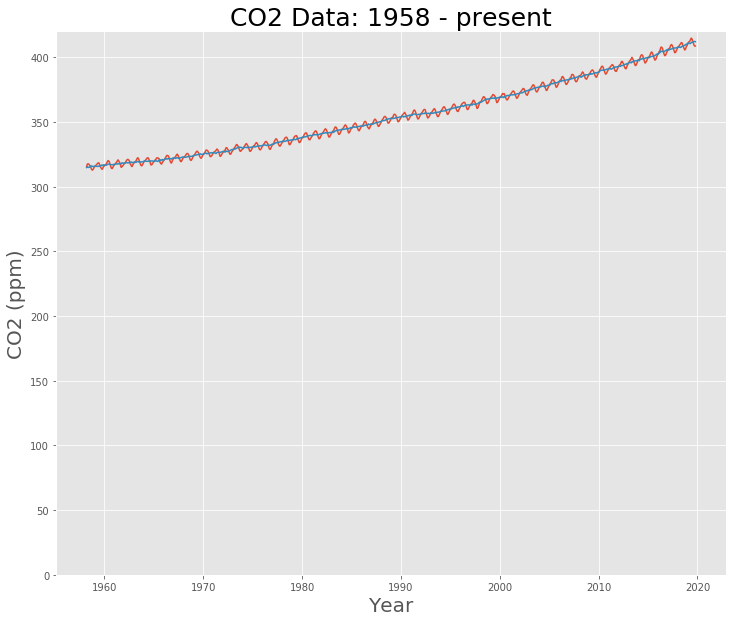

In [13]:
plt.style.use('ggplot')
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.ylim(bottom=0, top=420)
plt.plot(CO2['decimal_date'], CO2['CO2_ppm'])
plt.plot(CO2['decimal_date'], CO2['trend'])
plt.title('CO2 Data: 1958 - present', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('CO2 (ppm)', fontsize=20)
plt.show()

For a better understanding of the recent trend, I am zooming the y axis between 310 and 420 ppm

<Figure size 432x288 with 0 Axes>

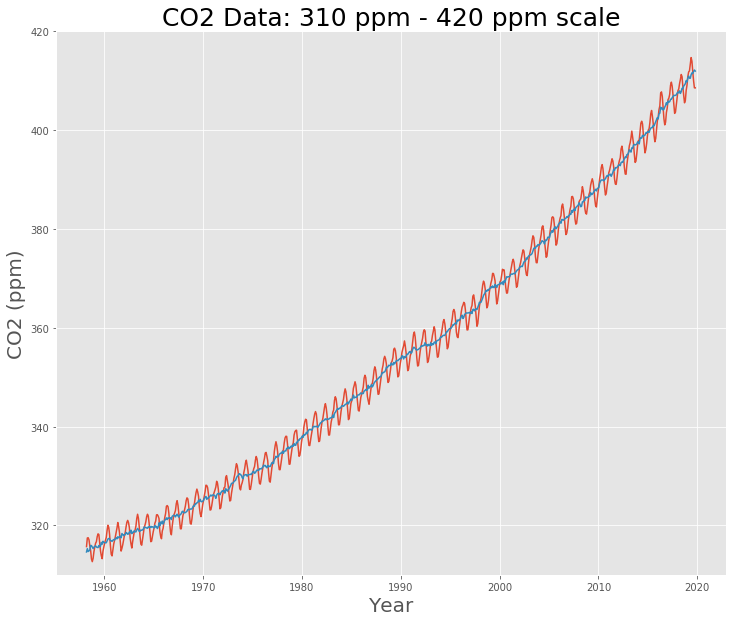

In [14]:
plt.style.use('ggplot')
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.ylim(bottom=310, top=420)
plt.plot(CO2['decimal_date'], CO2['CO2_ppm'])
plt.plot(CO2['decimal_date'], CO2['trend'])
plt.title('CO2 Data: 310 ppm - 420 ppm scale', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('CO2 (ppm)', fontsize=20)
plt.show()

The latest 20 years show an acceleration of the historical trend as shown below

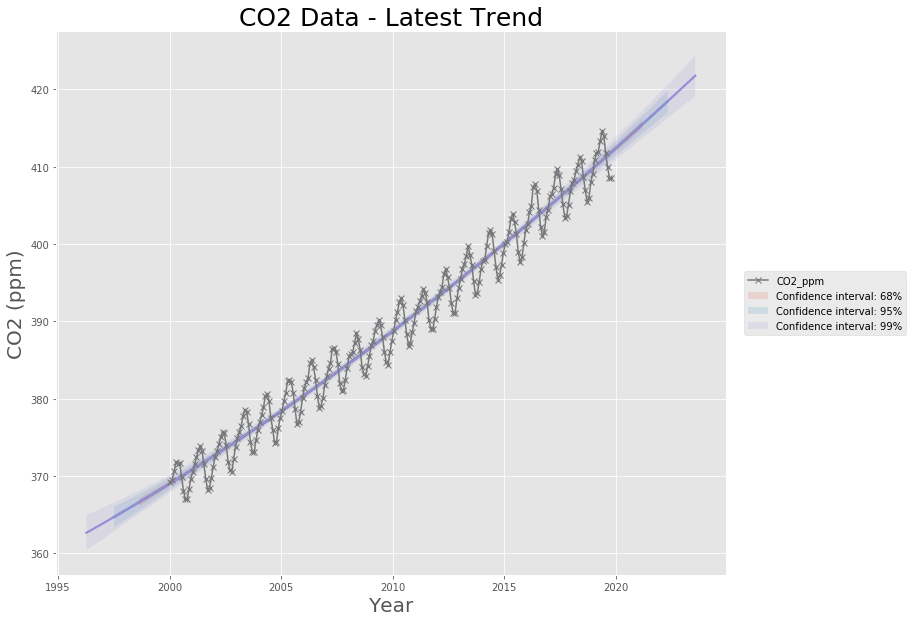

In [15]:
sd = {"sd1": 68.27, "sd2": 95.45, "sd3": 99.73}
detail_df=CO2[502:]
fig = plt.figure(figsize=(12, 10))
for sd_item in sd.keys():
    ax = sns.regplot(x='decimal_date', y='CO2_ppm', ci=sd[sd_item], data=detail_df, order=2, scatter_kws={'s':5})
plt.plot('decimal_date', 'CO2_ppm', data=detail_df, linestyle='-', marker='x')
plt.title('CO2 Data - Latest Trend', fontsize=25); plt.xlabel('Year', fontsize=20); plt.ylabel('CO2 (ppm)', fontsize=20)
ax.collections[1].set_label('Confidence interval: 68%')
ax.collections[3].set_label('Confidence interval: 95%')
ax.collections[5].set_label('Confidence interval: 99%')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
plt.show()

For the latest 20 years of data, the slope for the order 2 polynomial interpolation tends to increase. Selection of the proper polynomial order will be done later, by minimizing residuals

The goal is now to analyze the yearly maximums and minimums series

In [16]:
# Need to use .values for transforming the pandas series to a numpy array and use numpy functions for 1d arrays
print(type(CO2['CO2_ppm']))
print(type(CO2['CO2_ppm'].values))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [17]:
# get local maximums and minimums
maximums = argrelextrema(CO2['CO2_ppm'].values, np.greater_equal)[0]
minimums = argrelextrema(CO2['CO2_ppm'].values, np.less_equal)[0]

print('Local Maximums\n', maximums, '\n Number of maximums = ', len(maximums), '\n')
print('Local Minimums\n', minimums, '\n Number of minimums = ', len(minimums))

Local Maximums
 [  2  14  26  38  50  62  74  86  98 110 122 134 145 158 170 182 194 206
 218 230 242 255 266 278 290 302 314 326 338 350 362 374 386 398 410 422
 434 446 458 470 482 493 505 507 518 530 542 554 566 578 590 602 614 626
 638 650 662 674 686 698 710 722 734] 
 Number of maximums =  63 

Local Minimums
 [  0   7  19  31  42  55  67  78  91 103 114 115 127 139 150 162 174 187
 199 211 223 235 246 258 271 282 294 306 318 331 343 354 366 378 390 402
 414 426 438 451 462 474 486 498 506 510 522 535 547 558 570 582 594 607
 619 630 643 655 666 678 690 702 714 726 739] 
 Number of minimums =  65


Because I used np.greater_equal and np.less_equal in order not to lose flat maximums/minimums, there are 3 values to be deleted from minimums: the first value, the last value, the 11-th value (it is a flat minimum, the minimum is duplicated)

In [18]:
minimums = np.delete(minimums, [0, 11, 64])
print('Local Minimums\n', minimums, '\n Length minimums = ', len(minimums))

Local Minimums
 [  7  19  31  42  55  67  78  91 103 114 127 139 150 162 174 187 199 211
 223 235 246 258 271 282 294 306 318 331 343 354 366 378 390 402 414 426
 438 451 462 474 486 498 506 510 522 535 547 558 570 582 594 607 619 630
 643 655 666 678 690 702 714 726] 
 Length minimums =  62


The local CO2 maximums are reached around each 12 months, during the winter in the Northern Hemisphere. The Northern Hemisphere contains 68% of the Earth's land area and during the winter there is less CO2 eliminated by the Northern forests. Therefore local maximums for CO2 are located around the end of winter while local minimums are located around the end of summer as shown in the diagram below

<Figure size 432x288 with 0 Axes>

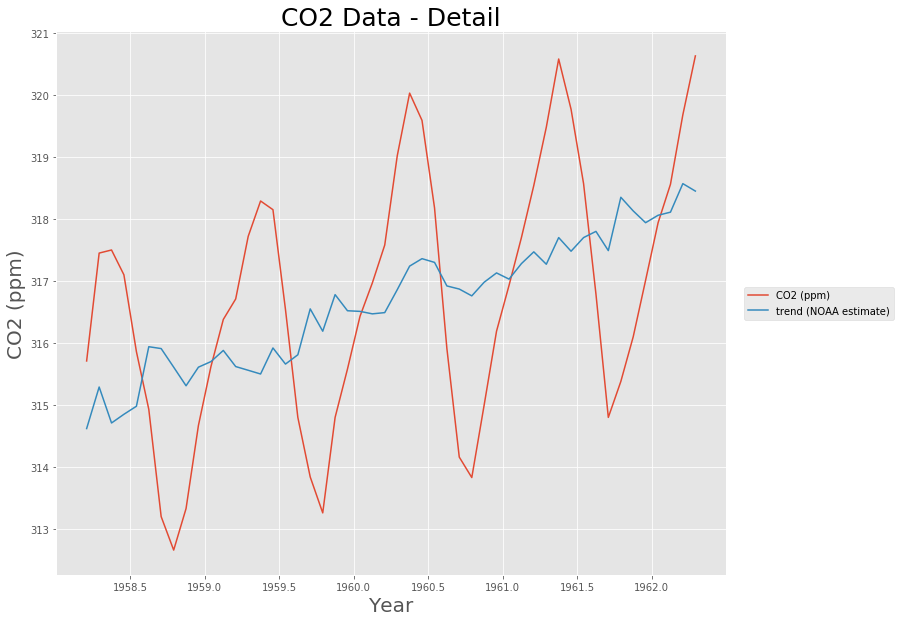

In [19]:
plt.style.use('ggplot')
detail_df=CO2.head(50)
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(detail_df['decimal_date'], detail_df['CO2_ppm'])
plt.plot(detail_df['decimal_date'], detail_df['trend'])
plt.legend(['CO2 (ppm)', 'trend (NOAA estimate)'], loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
plt.title('CO2 Data - Detail', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('CO2 (ppm)', fontsize=20)
plt.show()

One issue is the local variability or data reading errors that can create local minimums or maximums if these are defined by using only 3 succesive values, for example: low/high/low for a local maximum and high/low/high for a local minimum. The proper solution is to use numpy.convolve(): https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html and https://en.wikipedia.org/wiki/Convolution but this is outside the scope of this first capstone project.

The easy fix is just to look at the data and fix the issues manually. In the diagram below there is a clear exception in the middle, where we can see 2 local maximums during the spring of year 2000

<Figure size 432x288 with 0 Axes>

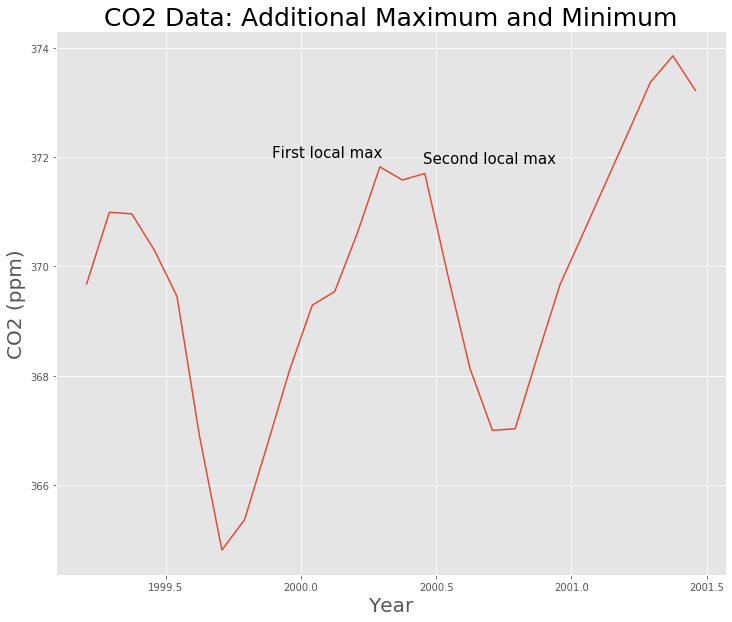

In [20]:
detail_df=CO2[492:520]
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(detail_df['decimal_date'], detail_df['CO2_ppm'])
plt.text(2000.3, 372, 'First local max', horizontalalignment='right', fontsize=15)
plt.text(2000.45, 371.9, 'Second local max', fontsize=15)
plt.title('CO2 Data: Additional Maximum and Minimum', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('CO2 (ppm)', fontsize=20)
plt.show()

This exception is shown in the data for rows 505 and 507. Row 507 will be deleted from maximums list

In [21]:
print(CO2.iloc[504]['CO2_ppm'], CO2.iloc[505]['CO2_ppm'], CO2.iloc[506]['CO2_ppm'],
      CO2.iloc[507]['CO2_ppm'], CO2.iloc[508]['CO2_ppm'])

370.6 371.82 371.58 371.7 369.86


In [22]:
print(maximums)

[  2  14  26  38  50  62  74  86  98 110 122 134 145 158 170 182 194 206
 218 230 242 255 266 278 290 302 314 326 338 350 362 374 386 398 410 422
 434 446 458 470 482 493 505 507 518 530 542 554 566 578 590 602 614 626
 638 650 662 674 686 698 710 722 734]


In [23]:
maximums = np.delete(maximums, 43)
print(maximums)

[  2  14  26  38  50  62  74  86  98 110 122 134 145 158 170 182 194 206
 218 230 242 255 266 278 290 302 314 326 338 350 362 374 386 398 410 422
 434 446 458 470 482 493 505 518 530 542 554 566 578 590 602 614 626 638
 650 662 674 686 698 710 722 734]


The minimum value just before 43 must also be deleted from minimums list

In [24]:
minimums = np.delete(minimums, 42)

Another issue is the lack of a local minimum at the end of the time series as shown below:

<Figure size 432x288 with 0 Axes>

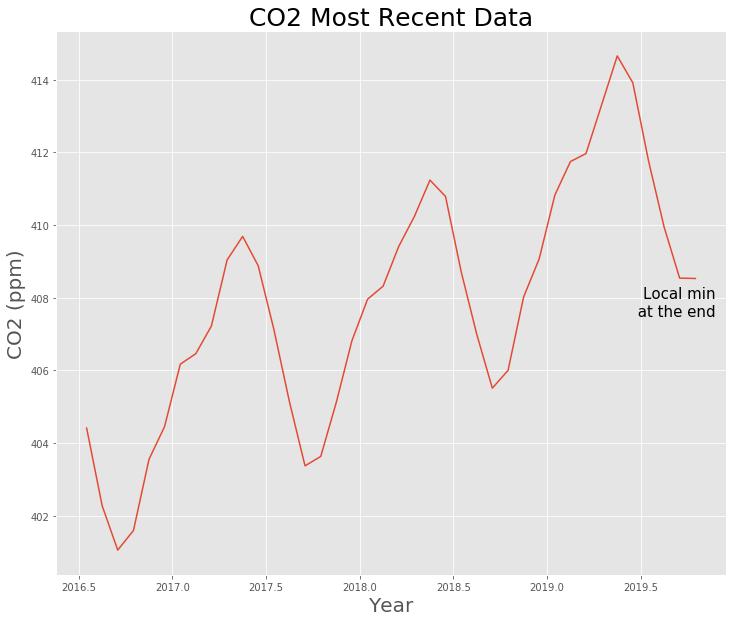

In [25]:
detail_df=CO2[700:]
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(detail_df['decimal_date'], detail_df['CO2_ppm'])
plt.text(2019.9, 407.5, 'Local min\n at the end', horizontalalignment='right', fontsize=15)
plt.title('CO2 Most Recent Data', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('CO2 (ppm)', fontsize=20)
plt.show()

From the shape of this diagram, it is clear that the last reading represents the local minimum. The local minimum is reached each year in September or October.

Therefore, I shall insert the last index value from the time series as a local minimum.

In [26]:
print(CO2.iloc[737]['CO2_ppm'], CO2.iloc[738]['CO2_ppm'], CO2.iloc[739]['CO2_ppm'])

409.95 408.54 408.53


In [27]:
minimums = np.append(minimums, 739)
print('Local Maximums\n', maximums, '\n Number of maximums = ', len(maximums), '\n')
print('Local Minimums\n', minimums, '\n Number of minimums = ', len(minimums))

Local Maximums
 [  2  14  26  38  50  62  74  86  98 110 122 134 145 158 170 182 194 206
 218 230 242 255 266 278 290 302 314 326 338 350 362 374 386 398 410 422
 434 446 458 470 482 493 505 518 530 542 554 566 578 590 602 614 626 638
 650 662 674 686 698 710 722 734] 
 Number of maximums =  62 

Local Minimums
 [  7  19  31  42  55  67  78  91 103 114 127 139 150 162 174 187 199 211
 223 235 246 258 271 282 294 306 318 331 343 354 366 378 390 402 414 426
 438 451 462 474 486 498 510 522 535 547 558 570 582 594 607 619 630 643
 655 666 678 690 702 714 726 739] 
 Number of minimums =  62


Check if maximums and minimums alternate

In [28]:
alternate = True
for item in zip(maximums, minimums):
    # each tuple must start with a maximum and end with a minimum
    # if the position of the maximum is greater than the position of minimum, the values do not alternate properly
    if item[0] >= item[1]:
        alternate = False
        break
print(alternate)

True


Therefore, the maximums and minimums alternate as expected

Create a list of differences between the local maximum and local minimum for each year

In [29]:
yearly_co2_diff = []
for item in zip(maximums, minimums):
    yearly_co2_diff.append(round(CO2.iloc[item[0]]['CO2_ppm'] - CO2.iloc[item[1]]['CO2_ppm'], 3))

<Figure size 432x288 with 0 Axes>

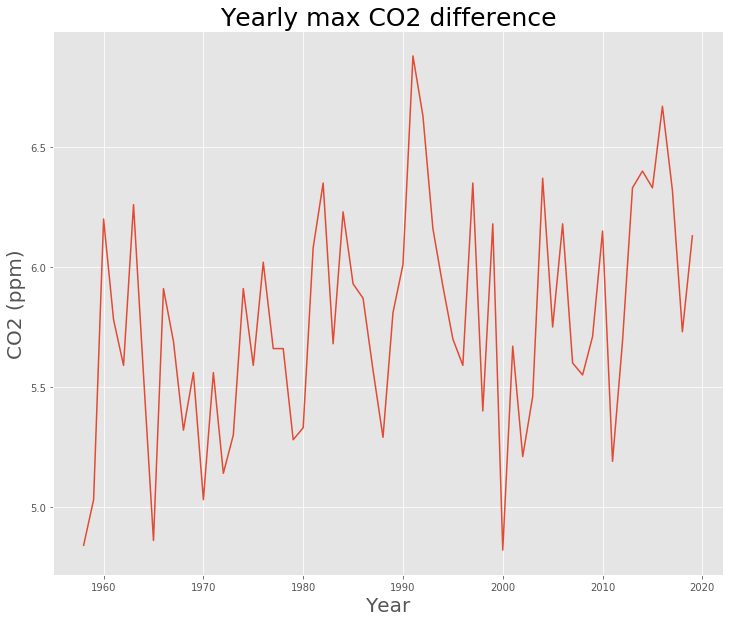

In [30]:
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(range(1958, 2020), yearly_co2_diff)
plt.title('Yearly max CO2 difference', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('CO2 (ppm)', fontsize=20)
plt.show()

It looks like there is a positive trend for this difference. This hypotesis must be tested:

In [31]:
co2_diff=pd.DataFrame()
co2_diff['Year']=range(1958, 2020)
co2_diff['CO2 difference']=yearly_co2_diff

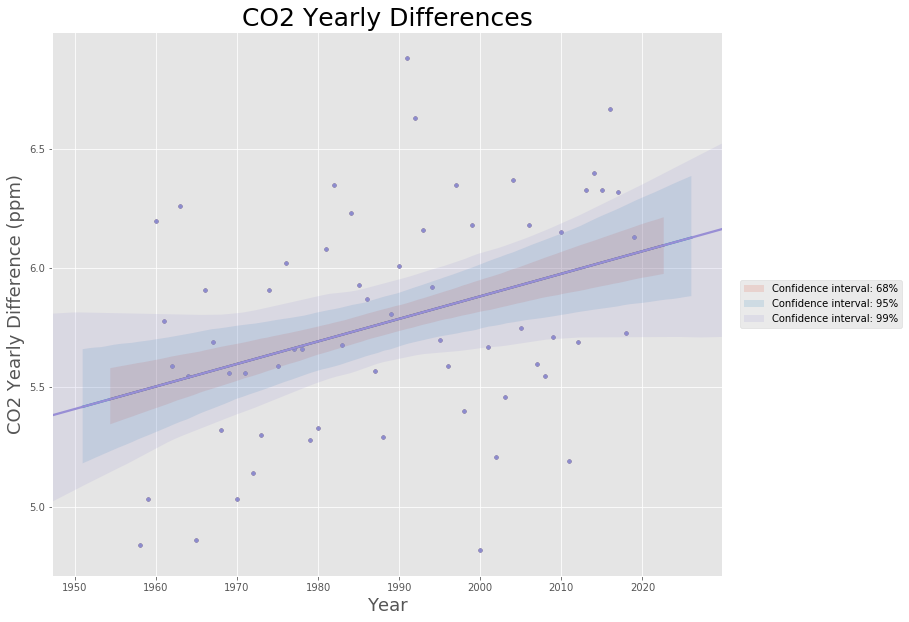

In [32]:
sd = {"sd1": 68.27, "sd2": 95.45, "sd3": 99.73}
fig = plt.figure(figsize=(12, 10))
for sd_item in sd.keys():
    ax = sns.regplot(x='Year', y='CO2 difference', data=co2_diff, ci=sd[sd_item], order=1, scatter_kws={'s':10})
plt.title('CO2 Yearly Differences', fontsize=25)
plt.xlabel('Year', fontsize=18)
plt.ylabel('CO2 Yearly Difference (ppm)', fontsize=18)
ax.collections[1].set_label('Confidence interval: 68%')
ax.collections[3].set_label('Confidence interval: 95%')
ax.collections[5].set_label('Confidence interval: 99%')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
plt.show()

The positive trend for yearly CO2 differences is confirmed.

In [33]:
# save the differences into a file
co2_diff.to_csv('./Data/co2/CO2_diff.csv',index=False)
co2_diff_new = pd.read_csv('./Data/co2/CO2_diff.csv', index_col = False)

In [34]:
co2_diff.head(3)

,Year,CO2 difference
0,1958,4.84
1,1959,5.03
2,1960,6.20


In [35]:
co2_diff_new.head(3)

,Year,CO2 difference
0,1958,4.84
1,1959,5.03
2,1960,6.20


In [36]:
CO2.set_index('decimal_date')

,Year,Month,CO2_ppm,trend
decimal_date,,,,
1958.208,1958,3,315.71,314.62
1958.292,1958,4,317.45,315.29
1958.375,1958,5,317.50,314.71
1958.458,1958,6,317.10,314.85
1958.542,1958,7,315.86,314.98
1958.625,1958,8,314.93,315.94
1958.708,1958,9,313.20,315.91
1958.792,1958,10,312.66,315.61
1958.875,1958,11,313.33,315.31


Check the long term CO2 trend by ignoring the yearly variance

Text(0.5, 1, 'Order 1 polynomial interpolation')

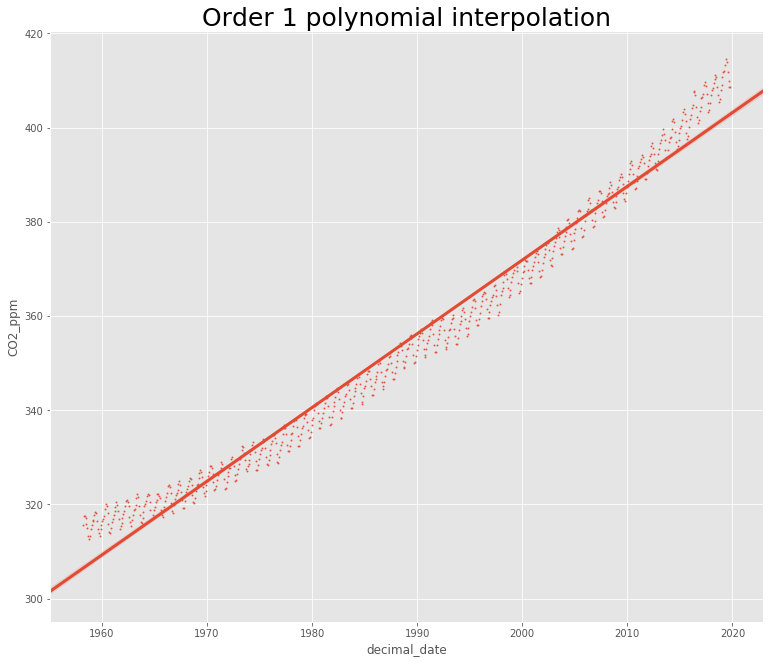

In [37]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=1,
           scatter_kws={"s": 1}, line_kws={"lw": 3})
plt.title('Order 1 polynomial interpolation', fontsize=25)

A simple order 1 regression is obviousely not a good fit for the data; will check with order 2

Text(0.5, 1, 'Order 2 polynomial interpolation')

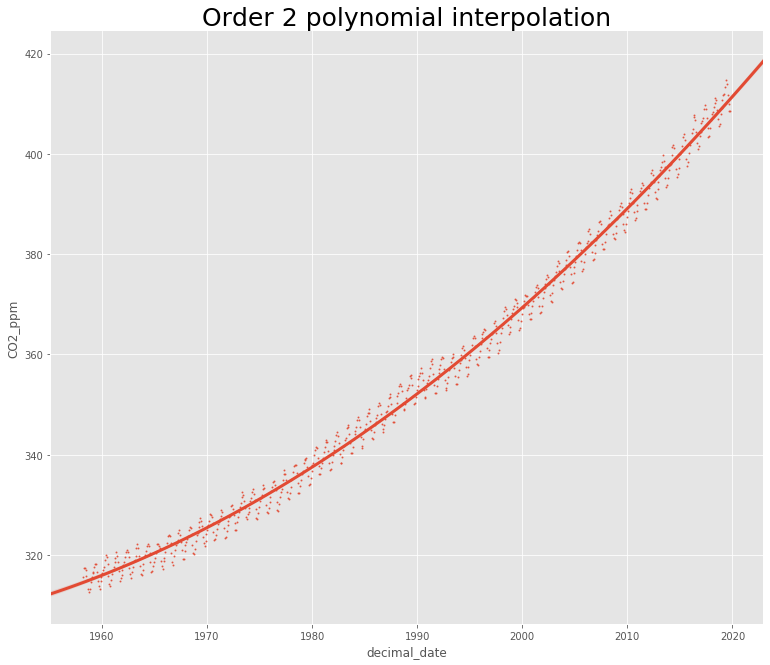

In [38]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=2,
           scatter_kws={"s": 1}, line_kws={"lw": 3})
plt.title('Order 2 polynomial interpolation', fontsize=25)

It looks like order 2 is a much better fit. Check if an order 3 is an even better fit

Text(0.5, 1, 'Order 3 polynomial interpolation')

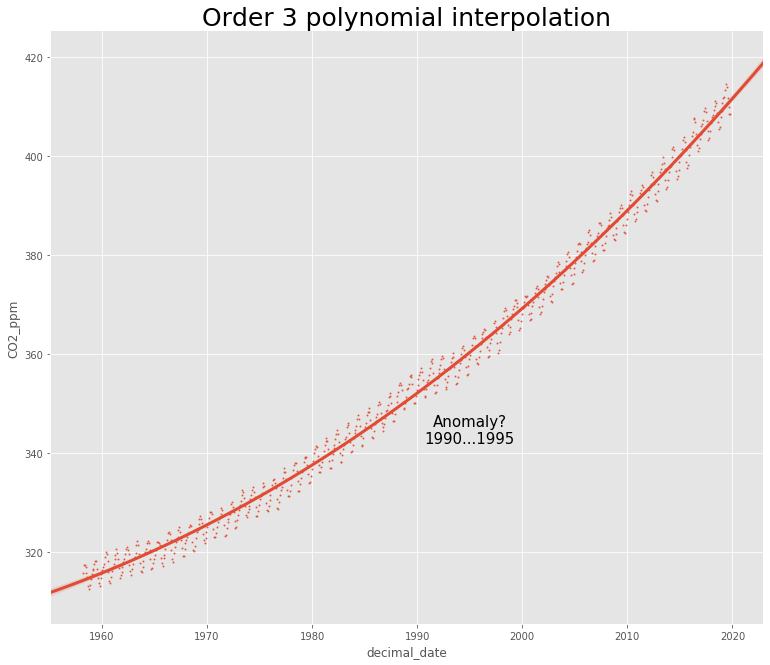

In [39]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=3,
           scatter_kws={"s": 1}, line_kws={"lw": 3})
plt.text(1995, 342, 'Anomaly?\n1990...1995', horizontalalignment='center', fontsize=15)
plt.title('Order 3 polynomial interpolation', fontsize=25)

Maybe this diagram can catch better the anomaly between 1990 and 1995 when CO2 was not increasing as before - but a conclusion will be taken by calculating the residuals.

By increasing the order too much there is a danger of overfitting the data.

Check other data visualisations options

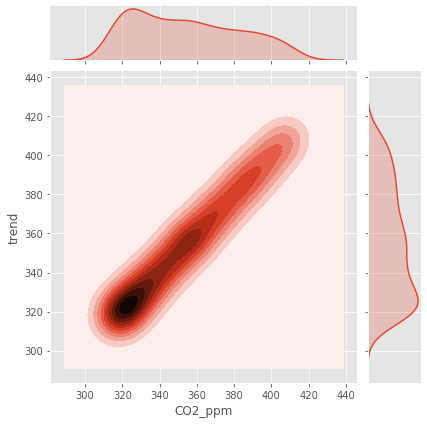

In [40]:
# This kde plot shows graphically how the CO2 stayed longer at concentrations around 320 ppm
# because the time spent on concentrations above 320 ppm is getting shorter
sns.jointplot(x='CO2_ppm',y='trend',data=CO2,kind='kde')

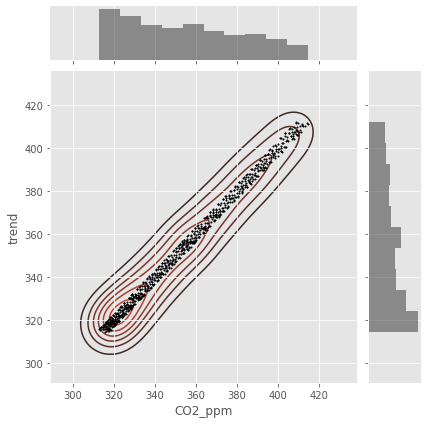

In [41]:
# another perspective of the same diagram, with histograms
sns.jointplot(x='CO2_ppm',y='trend',data=CO2,color="k",s=2).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

Text(0.5, 1.0, 'Boxplots: 1958 - 2019')

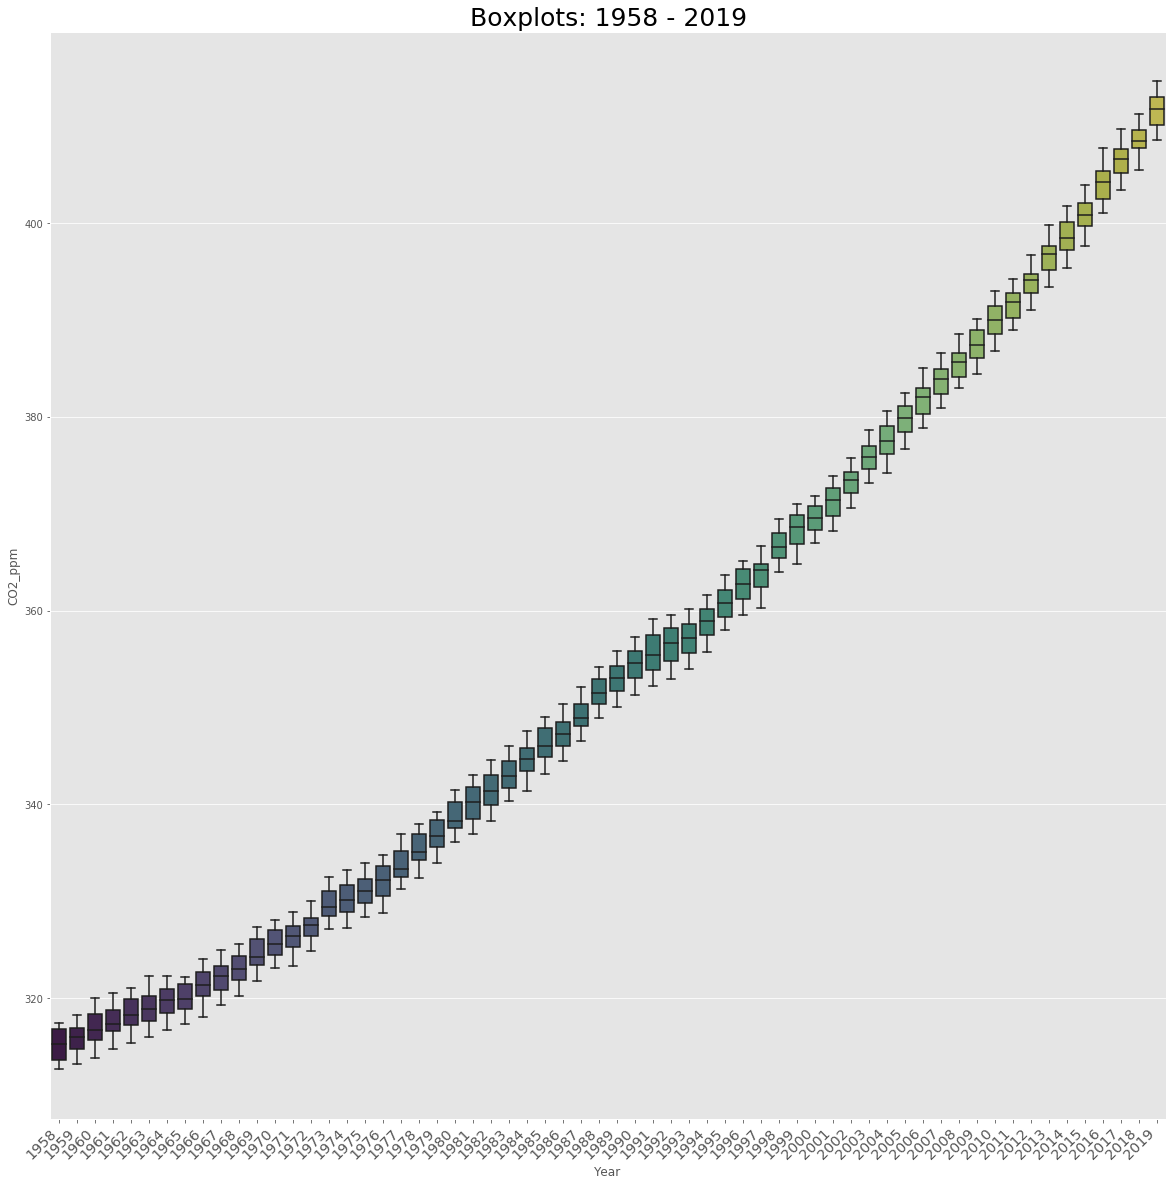

In [42]:
# boxplots, grouped by year
plt.figure(figsize=(20,20))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
sns.boxplot(x="Year", y="CO2_ppm", data=CO2, palette='viridis', saturation=0.5)
plt.title('Boxplots: 1958 - 2019', fontsize=25)

The boxplots tend to increase in size. The anomaly around 1990...1995 is clearly visible in the diagram above

In [43]:
CO2[['CO2_ppm', 'trend', 'decimal_date']].corr()

,CO2_ppm,trend,decimal_date
CO2_ppm,1.000000,0.997248,0.988534
trend,0.997248,1.000000,0.991284
decimal_date,0.988534,0.991284,1.000000


Text(0.5, 1, '\nHeatmap: year, CO2 (ppm), trend\n')

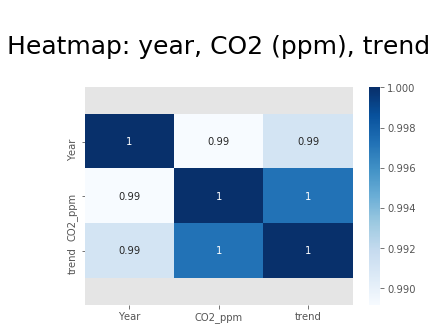

In [44]:
# Heatmap
ax = sns.heatmap(CO2[['Year', 'CO2_ppm', 'trend']].corr(),cmap='Blues',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('\nHeatmap: year, CO2 (ppm), trend\n', fontsize=25)

The correlation values between year and trend (and year and CO2_ppm) are huge. This confirms a very strong correletion between these fields.

EDA - ice

In [45]:
# Will show the map for every sea in the ice dataset...

<img src="Kara_Sea_map.png">

<Figure size 432x288 with 0 Axes>

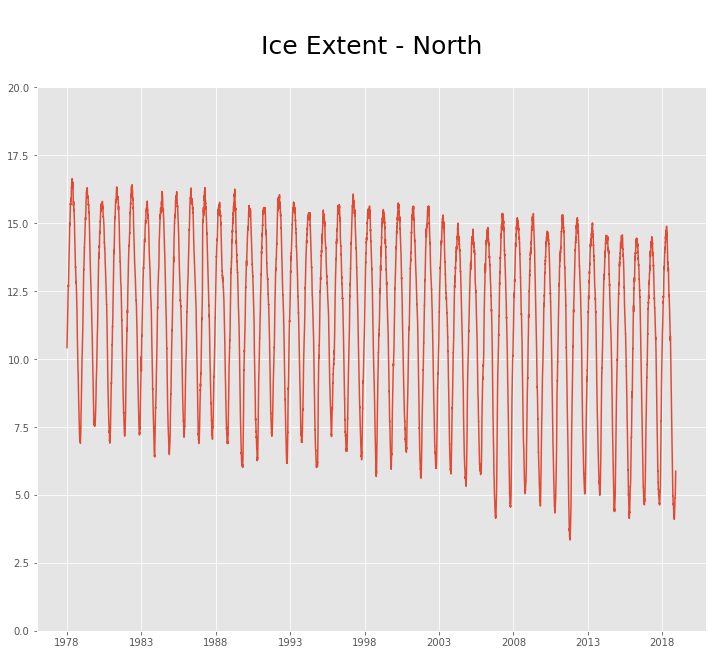

In [46]:
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.ylim(bottom=0, top=20)
plt.xticks([])
plt.xticks(np.arange(0, 15000, step=5*365), ('1978','1983','1988','1993','1998','2003','2008','2013','2018'))
plt.title('\nIce Extent - North\n', fontsize=25)
plt.plot(ice['North_ext'])
plt.show()

In [47]:
ice_temp = ice.reset_index()
ice_temp.columns

Index(['index', 'Baffin', 'Baffin-ext', 'Barents-ext', 'Beaufort', 'Barents',
       'Beaufort-ext', 'Bering', 'Bering-ext', 'Canadian', 'Canadian-ext',
       'Central-Arctic', 'Central-Arctic-ext', 'Chukchi', 'Chukchi-ext',
       'East-Siberian', 'East-Siberian-ext', 'Greenland', 'Greenland-ext',
       'Hudson', 'Hudson-ext', 'Kara', 'Kara-ext', 'Laptev', 'Laptev-ext',
       'Okhotsk', 'Okhotsk-ext', 'St-Lawrence', 'St-Lawrence-ext', 'North_ext',
       'South_ext'],
      dtype='object')

In [48]:
# need to add a decimal year as a float to the dataframe because seaborn gives the following error with datetime:
# TypeError: invalid type promotion

import datetime

def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

ice_temp['Year'] = list(map(lambda item: year_fraction(pd.to_datetime(item)), ice_temp['index']))

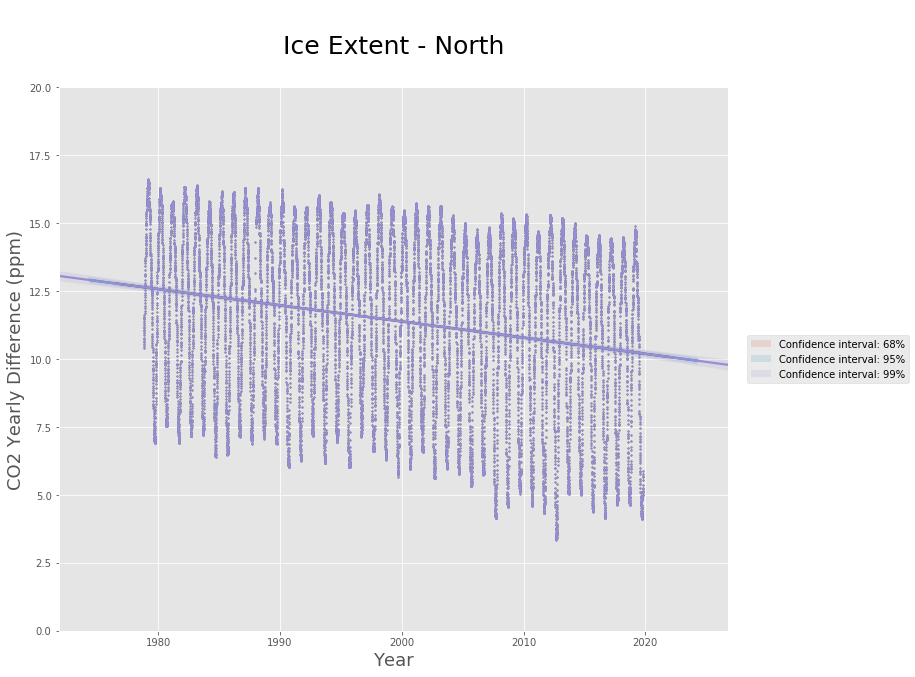

In [49]:
sd = {"sd1": 68.27, "sd2": 95.45, "sd3": 99.73}
fig = plt.figure(figsize=(12, 10))
plt.ylim(bottom=0, top=20)
for sd_item in sd.keys():
    ax = sns.regplot(x='Year', y=ice_temp['North_ext'], data=ice_temp, ci=sd[sd_item], order=1, scatter_kws={'s':1})
plt.title('\nIce Extent - North\n', fontsize=25)
plt.xlabel('Year', fontsize=18)
plt.ylabel('CO2 Yearly Difference (ppm)', fontsize=18)
ax.collections[1].set_label('Confidence interval: 68%')
ax.collections[3].set_label('Confidence interval: 95%')
ax.collections[5].set_label('Confidence interval: 99%')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
plt.show()

There is a clear yearly seasonal component and a downward component for the North ice extent.

<Figure size 432x288 with 0 Axes>

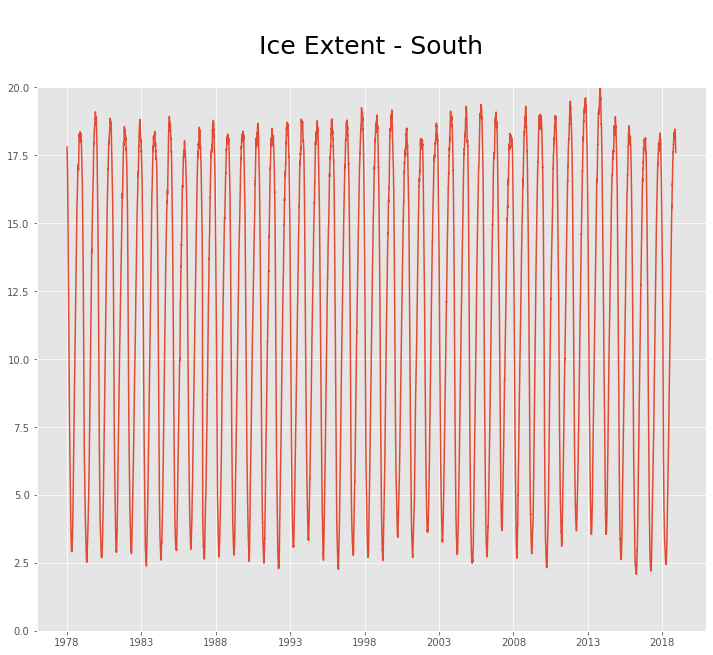

In [50]:
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.ylim(bottom=0, top=20)
plt.xticks([])
plt.xticks(np.arange(0, 15000, step=5*365), ('1978', '1983', '1988', '1993', '1998', '2003', '2008', '2013', '2018'))
plt.title('\nIce Extent - South\n', fontsize=25)
plt.plot(ice['South_ext'])
plt.show()

The trend for the South ice extent is not obvious.

In [51]:
ice.columns

Index(['Baffin', 'Baffin-ext', 'Barents-ext', 'Beaufort', 'Barents',
       'Beaufort-ext', 'Bering', 'Bering-ext', 'Canadian', 'Canadian-ext',
       'Central-Arctic', 'Central-Arctic-ext', 'Chukchi', 'Chukchi-ext',
       'East-Siberian', 'East-Siberian-ext', 'Greenland', 'Greenland-ext',
       'Hudson', 'Hudson-ext', 'Kara', 'Kara-ext', 'Laptev', 'Laptev-ext',
       'Okhotsk', 'Okhotsk-ext', 'St-Lawrence', 'St-Lawrence-ext', 'North_ext',
       'South_ext'],
      dtype='object')

Text(0.5, 1, '\nHeatmap: Ice Dataset\n')

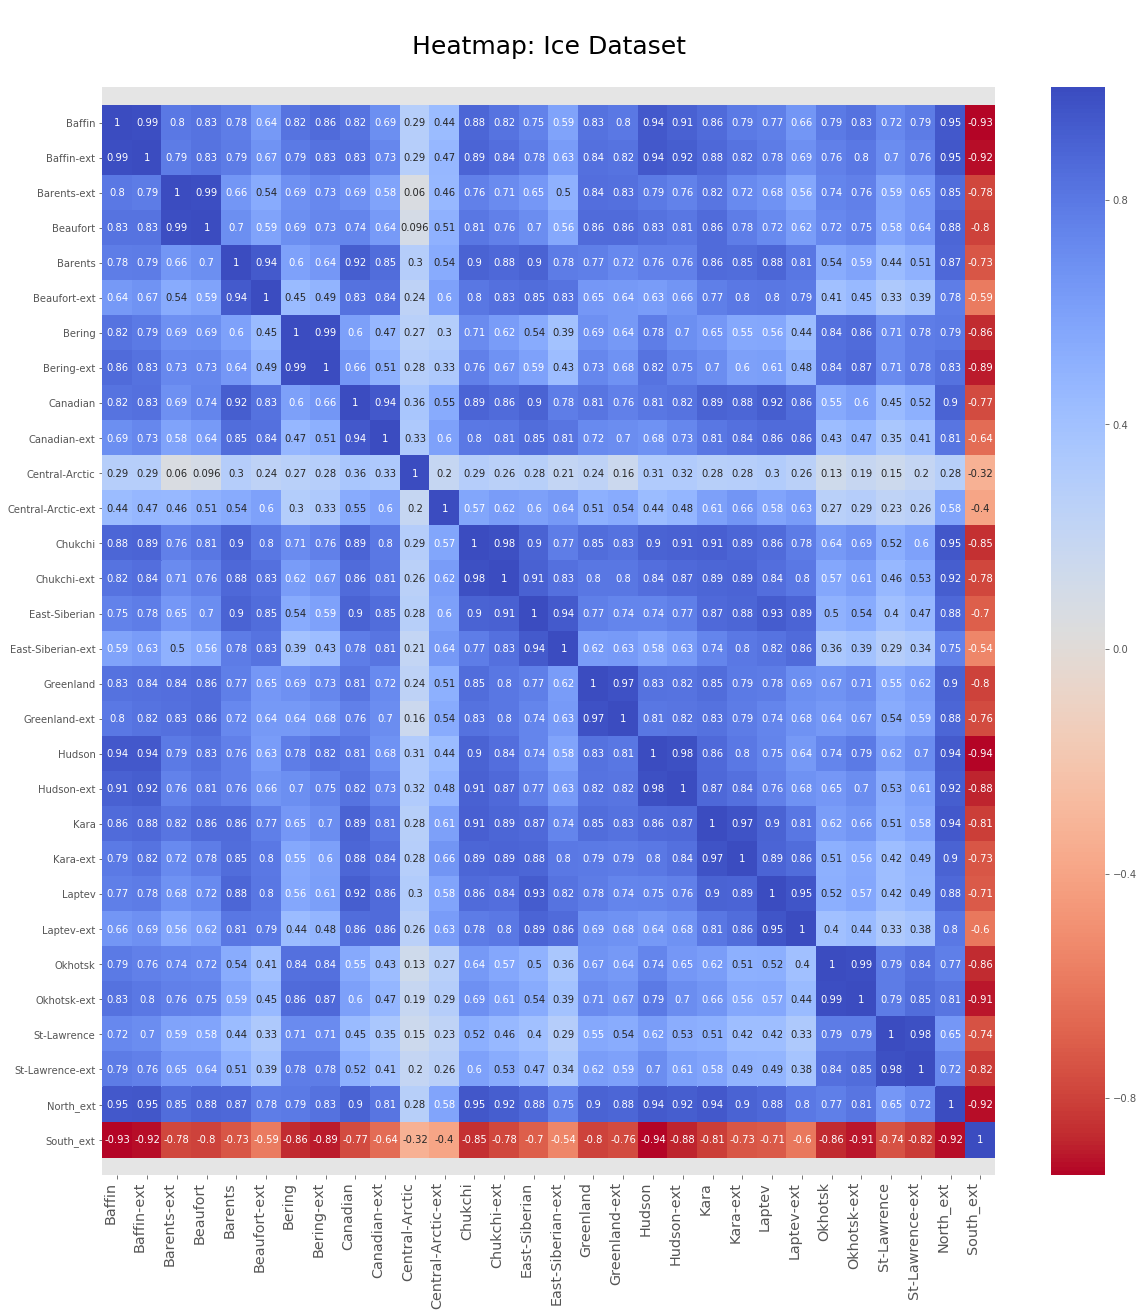

In [52]:
# Heatmap for the ice dataset
plt.figure(figsize=(20,20))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
ax = sns.heatmap(ice.corr(),cmap='coolwarm_r',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('\nHeatmap: Ice Dataset\n', fontsize=25)

As expected, sea ice and sea ice extent are highly correlated for each Northern sea. An exception is Central-Arctic and Central_Arctic-Extent.

There is no data for Southern seas, the only feature is 'South_ext'

I shall reorder the seas by correlation values (descending)

In [53]:
sea_names=['Baffin', 'Beaufort', 'Barents', 'Bering', 'Canadian', 'Central-Arctic', 'Chukchi', 'East-Siberian',
           'Greenland', 'Hudson', 'Kara', 'Laptev', 'Okhotsk', 'St-Lawrence', 'North_ext', 'South_ext']

In [54]:
sea_df=pd.DataFrame()
for sea in sea_names:
    print(sea)
    sea_df=sea_df.append(ice[sea])

Baffin
Beaufort
Barents
Bering
Canadian
Central-Arctic
Chukchi
East-Siberian
Greenland
Hudson
Kara
Laptev
Okhotsk
St-Lawrence
North_ext
South_ext


In [55]:
# As a metric for correlation, I am using the sum of squares.
# I keep the sign for maintaining negative correlations as well. I am using L2 metric with a sign
# Strangely enough, there is no sign function so this function must be created
import math
sign = lambda x: math.copysign(1, x)

In [56]:
sign(0)

1.0

In [57]:
sign(77)

1.0

In [58]:
sign(-1.4)

-1.0

In [59]:
correlations = {}
for sea1 in sea_names:
    total_correlation = 0.
    for sea2 in sea_names:
        total_correlation += sign(sea_df.loc[sea1].corr(sea_df.loc[sea2]))*(sea_df.loc[sea1].corr(sea_df.loc[sea2]))**2
    correlations[sea1] = total_correlation

In [60]:
correlations

{'Baffin': 9.16867270599108,
 'Beaufort': 8.031381036174716,
 'Barents': 8.397210043597195,
 'Bering': 6.646150373181579,
 'Canadian': 8.846589420076898,
 'Central-Arctic': 1.8880762177905521,
 'Chukchi': 9.378389683476756,
 'East-Siberian': 8.285833059423528,
 'Greenland': 8.489398526620214,
 'Hudson': 8.780138239892153,
 'Kara': 9.255378709228886,
 'Laptev': 8.423801608125837,
 'Okhotsk': 6.218978519405422,
 'St-Lawrence': 4.82028434335858,
 'North_ext': 10.130380662643207,
 'South_ext': -8.493526944156573}

As expected, the overall highest positive correlation is for North_ext and the overall lowest negative correlation is for South_ext.

In [61]:
ordered_seas = []
from operator import itemgetter
for key, value in sorted(correlations.items(), key=itemgetter(1), reverse=True):
    print(key, value)
    ordered_seas.append(key)
    if ((key != 'North_ext') & (key != 'South_ext')):
        ordered_seas.append(key+'-ext')

North_ext 10.130380662643207
Chukchi 9.378389683476756
Kara 9.255378709228886
Baffin 9.16867270599108
Canadian 8.846589420076898
Hudson 8.780138239892153
Greenland 8.489398526620214
Laptev 8.423801608125837
Barents 8.397210043597195
East-Siberian 8.285833059423528
Beaufort 8.031381036174716
Bering 6.646150373181579
Okhotsk 6.218978519405422
St-Lawrence 4.82028434335858
Central-Arctic 1.8880762177905521
South_ext -8.493526944156573


In [62]:
print(ordered_seas)

['North_ext', 'Chukchi', 'Chukchi-ext', 'Kara', 'Kara-ext', 'Baffin', 'Baffin-ext', 'Canadian', 'Canadian-ext', 'Hudson', 'Hudson-ext', 'Greenland', 'Greenland-ext', 'Laptev', 'Laptev-ext', 'Barents', 'Barents-ext', 'East-Siberian', 'East-Siberian-ext', 'Beaufort', 'Beaufort-ext', 'Bering', 'Bering-ext', 'Okhotsk', 'Okhotsk-ext', 'St-Lawrence', 'St-Lawrence-ext', 'Central-Arctic', 'Central-Arctic-ext', 'South_ext']


In [63]:
ice_new = pd.DataFrame()

In [64]:
for sea in ordered_seas:
    ice_new[sea] = ice[sea]

In [65]:
print(len(ice_new.columns), len(ice.columns))

30 30


Text(0.5, 1, '\nHeatmap: Ice Dataset (ordered by correlation)\n')

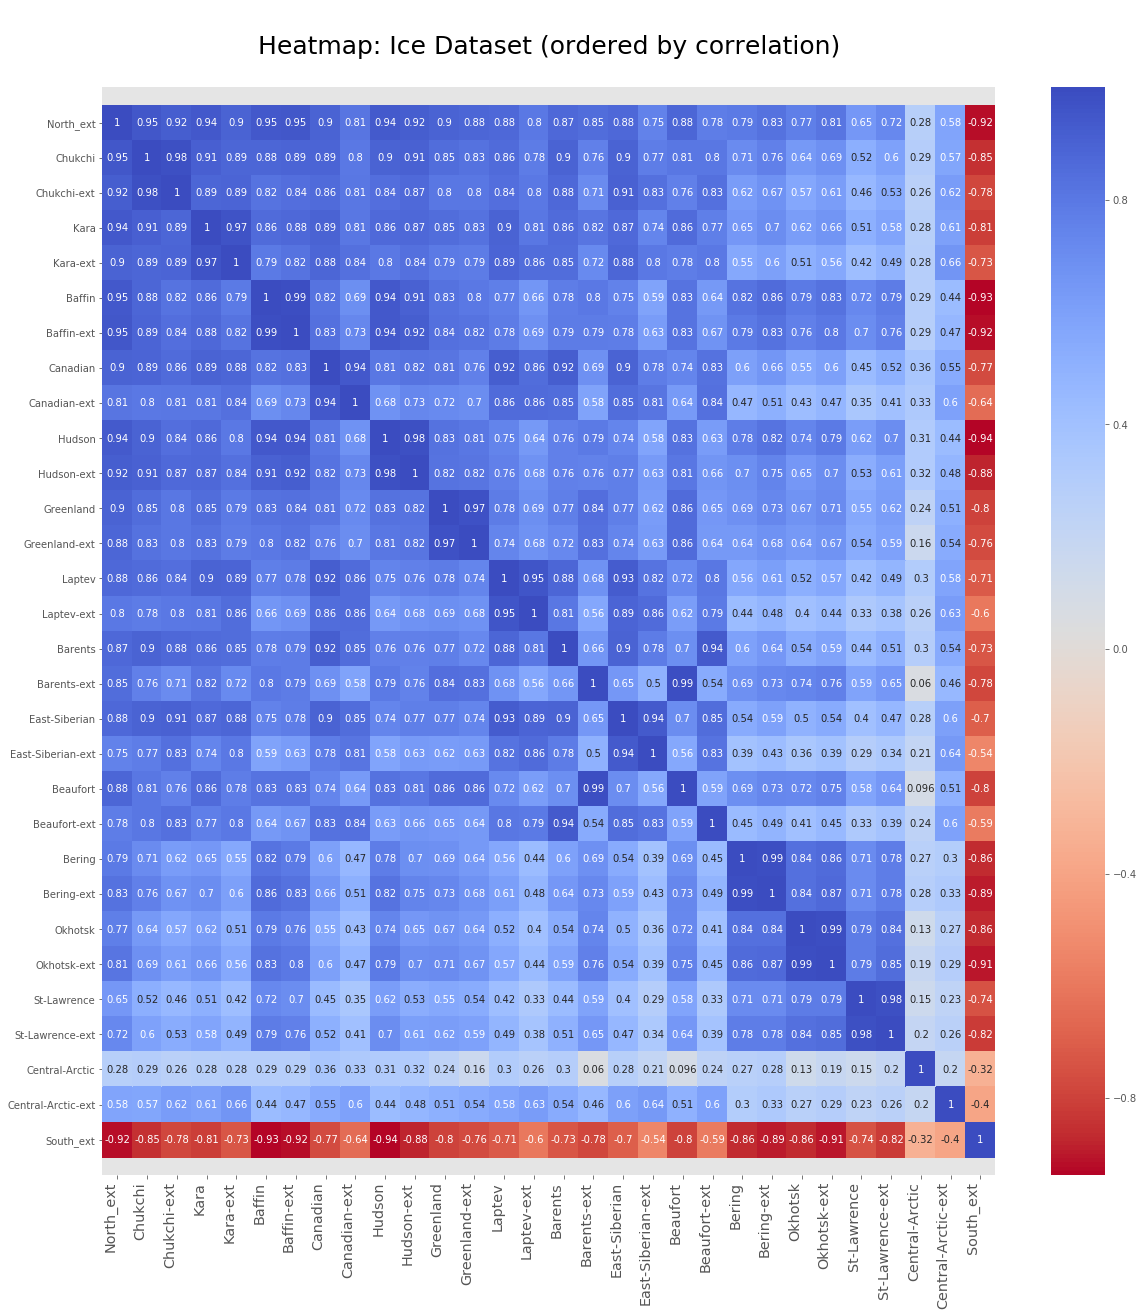

In [66]:
plt.figure(figsize=(20,20))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
ax = sns.heatmap(ice_new.corr(),cmap='coolwarm_r',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('\nHeatmap: Ice Dataset (ordered by correlation)\n', fontsize=25)

Notes:

- As expected, the correlation on the first diagonal is 1.

- North_ext and South_ext are global features, the ice extent from the North Pole and South Pole. It is natural to have the North_ext with the highest positive correlation with all the Northern seas and South_ext to have the lowest negative correlation with any other feature

- It is natural to have high correlation between sea ice extent and the sea itself. For example, the correlation can reach 0.99 between Baffin and Baffin_ext

- The correlation between Central-Arctic and Central_arctic-ext barely reach the value of 0.2. This anomaly will be investigated later

In [67]:
ice_new['North_and_South'] = ice['North_ext']+ice['South_ext']

Text(0.5, 1, '\nHeatmap: Ordered Ice Dataset and Total Ice Extent\n')

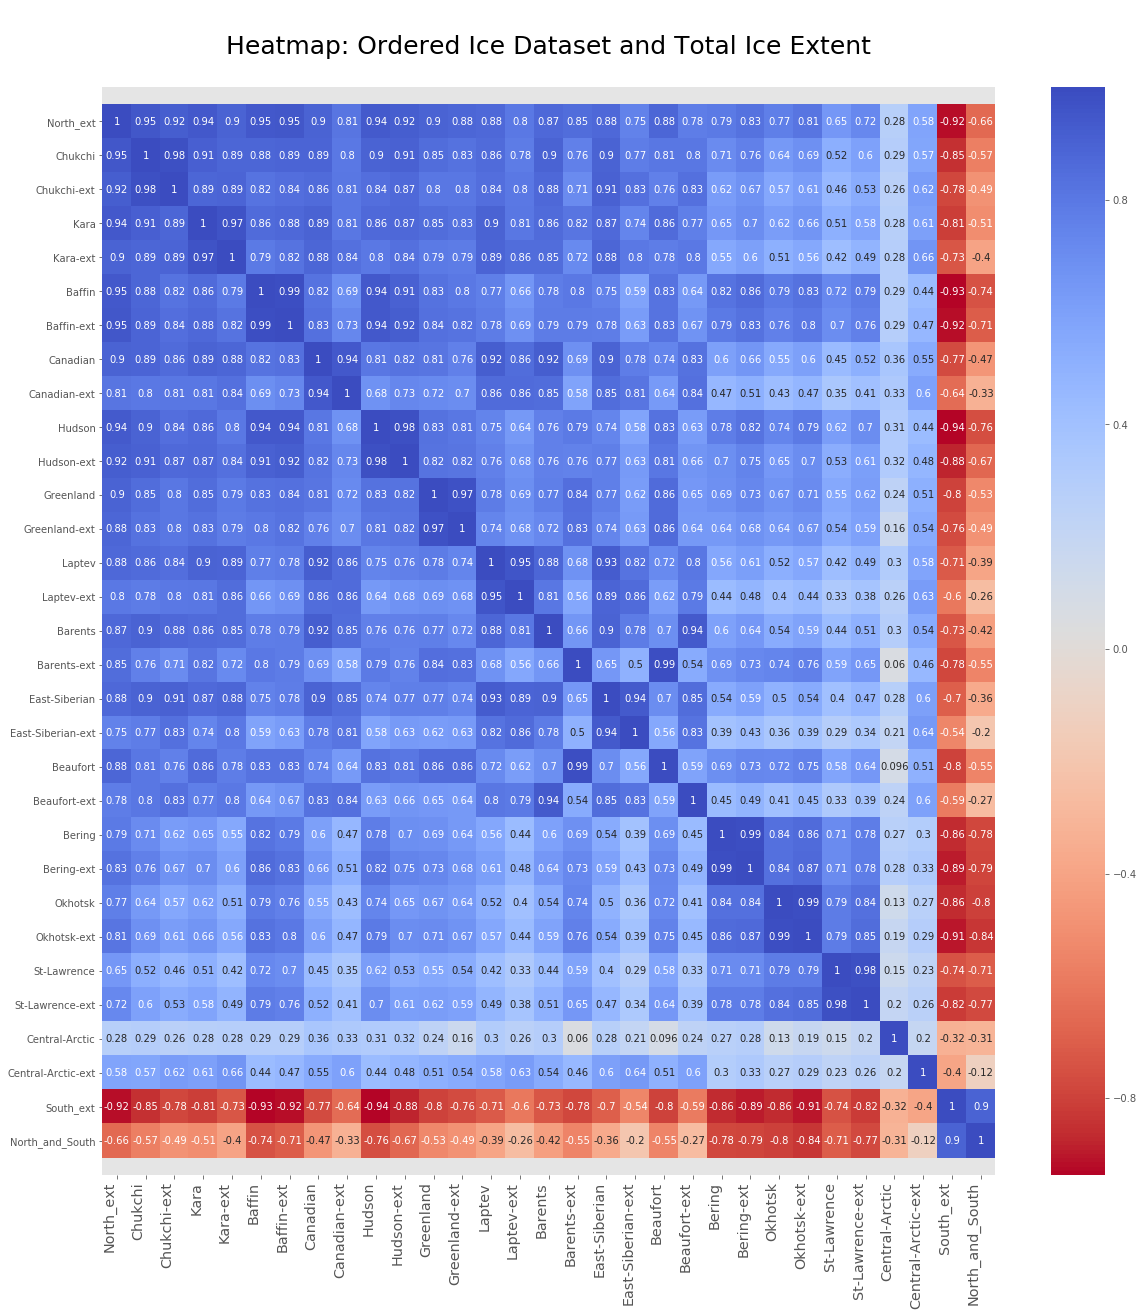

In [68]:
plt.figure(figsize=(20,20))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
ax = sns.heatmap(ice_new.corr(),cmap='coolwarm_r',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('\nHeatmap: Ordered Ice Dataset and Total Ice Extent\n', fontsize=25)

I added a new feature, 'North_and_South' - calculated as the sum of the North_ext and South_ext.

In the heatmap above, this new feature is positively correlated only with South extent (with a signifficant value, 0.9) and negatively correlated with any other feature. This is an interesting observation that shows how important the Antarctic region is for the global sea ice.

Add CO2 data to the ice dataframe

In [69]:
CO2.head(3)

,Year,Month,decimal_date,CO2_ppm,trend
0,1958,3,1958.208,315.71,314.62
1,1958,4,1958.292,317.45,315.29
2,1958,5,1958.375,317.50,314.71


In [70]:
CO2.tail(3)

,Year,Month,decimal_date,CO2_ppm,trend
737,2019,8,2019.625,409.95,411.86
738,2019,9,2019.708,408.54,412.14
739,2019,10,2019.792,408.53,411.93


In [71]:
ice_new.index.min()

'1978-10-28'

In [72]:
ice_new.index.max()

'2019-10-22'

In [73]:
ice_new.columns

Index(['North_ext', 'Chukchi', 'Chukchi-ext', 'Kara', 'Kara-ext', 'Baffin',
       'Baffin-ext', 'Canadian', 'Canadian-ext', 'Hudson', 'Hudson-ext',
       'Greenland', 'Greenland-ext', 'Laptev', 'Laptev-ext', 'Barents',
       'Barents-ext', 'East-Siberian', 'East-Siberian-ext', 'Beaufort',
       'Beaufort-ext', 'Bering', 'Bering-ext', 'Okhotsk', 'Okhotsk-ext',
       'St-Lawrence', 'St-Lawrence-ext', 'Central-Arctic',
       'Central-Arctic-ext', 'South_ext', 'North_and_South'],
      dtype='object')

In [74]:
ice_new.head(3)

,North_ext,Chukchi,Chukchi-ext,Kara,Kara-ext,Baffin,Baffin-ext,Canadian,Canadian-ext,Hudson,...,Bering,Bering-ext,Okhotsk,Okhotsk-ext,St-Lawrence,St-Lawrence-ext,Central-Arctic,Central-Arctic-ext,South_ext,North_and_South
1978-10-28,10.4200,512197.242,612396.111,569610.622,815398.750,416908.720,521862.289,719220.320,761228.252,246180.927,...,11472.805,35555.883,16799.581,35135.582,0.0,0.0,1862320.419,3224681.689,17.8030,28.223
1978-10-29,10.4885,512197.242,612396.111,569610.622,815398.750,416908.720,521862.289,719220.320,761228.252,246180.927,...,11472.805,35555.883,16799.581,35135.582,0.0,0.0,1862320.419,3224681.689,17.7365,28.225
1978-10-30,10.5570,520961.376,624383.567,562328.391,816017.367,419829.102,531533.703,717303.629,761228.252,261666.759,...,13553.099,42670.305,18745.308,39102.698,0.0,0.0,1859850.012,3224681.689,17.6700,28.227


For adding CO2 data to the ice data, the data must be selected only between 1978 and 2019. There must be an interpolation for getting daily data instead of monthly data.

In [76]:
# CO2 data is acquired on the 15th of each month
def to_acq_date(year, month):
    return (str(year)+'-'+str(month).zfill(2)+'-15')

In [77]:
to_acq_date(2019, 11)

'2019-11-15'

In [78]:
CO2_date=[]
for i in range(len(CO2)):
    CO2_date.append(to_acq_date(CO2['Year'][i], CO2['Month'][i]))

In [79]:
print(CO2_date[0], CO2_date[-1], len(CO2_date))

1958-03-15 2019-10-15 740


In [80]:
CO2_new=CO2.copy()

In [81]:
CO2_new['Date']=CO2_date

In [82]:
CO2_new.tail()

,Year,Month,decimal_date,CO2_ppm,trend,Date
735,2019,6,2019.458,413.92,411.57,2019-06-15
736,2019,7,2019.542,411.77,411.42,2019-07-15
737,2019,8,2019.625,409.95,411.86,2019-08-15
738,2019,9,2019.708,408.54,412.14,2019-09-15
739,2019,10,2019.792,408.53,411.93,2019-10-15


In [83]:
CO2_new=CO2_new.set_index('Date')

In [84]:
CO2_new.drop(['Year', 'Month', 'decimal_date'], axis=1, inplace=True)

In [85]:
CO2_new.index.name = None

In [86]:
CO2_new.head(3)

,CO2_ppm,trend
1958-03-15,315.71,314.62
1958-04-15,317.45,315.29
1958-05-15,317.50,314.71


In [87]:
CO2_new.tail(3)

,CO2_ppm,trend
2019-08-15,409.95,411.86
2019-09-15,408.54,412.14
2019-10-15,408.53,411.93


In [88]:
CO2_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 740 entries, 1958-03-15 to 2019-10-15
Data columns (total 2 columns):
CO2_ppm    740 non-null float64
trend      740 non-null float64
dtypes: float64(2)
memory usage: 17.3+ KB


In [89]:
ice_date = list(ice.index)

In [90]:
print(ice_date[0], ice_date[-1], len(ice_date))

1978-10-28 2019-10-22 14931


In [91]:
# Add lines for 15 Oct...27 Oct 1978
ice_date_temp = []
from datetime import date, timedelta

sdate = date(1978, 10, 15)   # start date
edate = date(1978, 10, 27)   # end date

delta = edate - sdate        # as timedelta

for i in range(delta.days + 1):
    ice_date_temp.append(str(sdate + timedelta(days=i)))

In [92]:
# Add main data
ice_date_temp = ice_date_temp+ice_date

In [93]:
# Add data between 23 Oct and 11 Nov 2019
sdate = date(2019, 10, 23)
edate = date(2019, 11, 15)

delta = edate - sdate

for i in range(delta.days + 1):
    ice_date_temp.append(str(sdate + timedelta(days=i)))

In [94]:
print(ice_date[0], ice_date[-1], len(ice_date))

1978-10-28 2019-10-22 14931


In [95]:
print(ice_date_temp[0], ice_date_temp[-1], len(ice_date_temp))

1978-10-15 2019-11-15 14968


In [96]:
# check if all dates are unique
print(len(ice_date_temp), len(set(ice_date_temp)))

14968 14968


In [97]:
temp_df = pd.DataFrame()

In [98]:
temp_df['Date'] = ice_date_temp

In [99]:
temp_df.head(3)

,Date
0,1978-10-15
1,1978-10-16
2,1978-10-17


In [100]:
temp_df.tail(3)

,Date
14965,2019-11-13
14966,2019-11-14
14967,2019-11-15


In [101]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14968 entries, 0 to 14967
Data columns (total 1 columns):
Date    14968 non-null object
dtypes: object(1)
memory usage: 117.0+ KB


In [102]:
temp_df = temp_df.set_index('Date')
temp_df.index.name=None

In [103]:
temp_df.head(3)

""
1978-10-15
1978-10-16
1978-10-17


In [104]:
temp_df.tail(3)

""
2019-11-13
2019-11-14
2019-11-15


In [105]:
CO2_new.head(3)

,CO2_ppm,trend
1958-03-15,315.71,314.62
1958-04-15,317.45,315.29
1958-05-15,317.50,314.71


In [106]:
CO2_new.tail(3)

,CO2_ppm,trend
2019-08-15,409.95,411.86
2019-09-15,408.54,412.14
2019-10-15,408.53,411.93


In [107]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14968 entries, 1978-10-15 to 2019-11-15
Empty DataFrame

In [108]:
new_temp_df = temp_df.merge(CO2_new, left_index=True, right_index=True, how='left')

In [109]:
new_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14968 entries, 1978-10-15 to 2019-11-15
Data columns (total 2 columns):
CO2_ppm    492 non-null float64
trend      492 non-null float64
dtypes: float64(2)
memory usage: 990.8+ KB


In [110]:
new_temp_df.head(3)

,CO2_ppm,trend
1978-10-15,332.41,335.68
1978-10-16,NaN,NaN
1978-10-17,NaN,NaN


In [111]:
new_temp_df.tail(3)

,CO2_ppm,trend
2019-11-13,NaN,NaN
2019-11-14,NaN,NaN
2019-11-15,NaN,NaN


In [112]:
new_temp_df.loc['2019-11-15']

CO2_ppm   NaN
trend     NaN
Name: 2019-11-15, dtype: float64

In [113]:
# Since the data was acquired, a new row of data become available (the values at Nov 15th)
# so the interpolation for the last values is now possible
new_temp_df.loc['2019-11-15'] = [410.21, 411.96]

In [114]:
new_temp_df.tail(3)

,CO2_ppm,trend
2019-11-13,NaN,NaN
2019-11-14,NaN,NaN
2019-11-15,410.21,411.96


In [115]:
# interpolate the two columns. Use linear interpolation.
new_temp_df['CO2_ppm'] = new_temp_df['CO2_ppm'].interpolate()
new_temp_df['trend'] = new_temp_df['trend'].interpolate()

In [116]:
new_temp_df.head(3)

,CO2_ppm,trend
1978-10-15,332.410000,335.68
1978-10-16,332.453226,335.69
1978-10-17,332.496452,335.70


In [117]:
print(ice_date[0], ice_date[-1], len(ice_date))

1978-10-28 2019-10-22 14931


In [118]:
print(new_temp_df.index[0], new_temp_df.index[-1], len(new_temp_df))

1978-10-15 2019-11-15 14968


In [119]:
# drop the first 13 top rows and the last 24 bottom rows from new_temp_df
new_temp_df = new_temp_df.reset_index()
new_temp_df.drop(list(range(13)), inplace=True)
new_temp_df.drop(list(range(new_temp_df.index.max()-23, new_temp_df.index.max()+1)), inplace=True)
new_temp_df = new_temp_df.set_index('index')

In [120]:
print(new_temp_df.index[0], new_temp_df.index[-1], len(new_temp_df))

1978-10-28 2019-10-22 14931


In [121]:
# Merge Ice and CO2 dataframes
print('\nIce min date: ', ice_new.index.min(), ' Ice max date: ', ice_new.index.min(),
      '\nCO2 min date: ', new_temp_df.index.min(), ' CO2 max date: ', new_temp_df.index.min())


Ice min date:  1978-10-28  Ice max date:  1978-10-28 
CO2 min date:  1978-10-28  CO2 max date:  1978-10-28


In [122]:
ice_and_co2 = pd.DataFrame()
ice_and_co2 = ice_new.merge(new_temp_df, left_index=True, right_index=True)

In [123]:
ice_and_co2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14931 entries, 1978-10-28 to 2019-10-22
Data columns (total 33 columns):
North_ext             14931 non-null float64
Chukchi               14931 non-null float64
Chukchi-ext           14931 non-null float64
Kara                  14931 non-null float64
Kara-ext              14931 non-null float64
Baffin                14931 non-null float64
Baffin-ext            14931 non-null float64
Canadian              14931 non-null float64
Canadian-ext          14931 non-null float64
Hudson                14931 non-null float64
Hudson-ext            14931 non-null float64
Greenland             14931 non-null float64
Greenland-ext         14931 non-null float64
Laptev                14931 non-null float64
Laptev-ext            14931 non-null float64
Barents               14931 non-null float64
Barents-ext           14931 non-null float64
East-Siberian         14931 non-null float64
East-Siberian-ext     14931 non-null float64
Beaufort              14931

Text(0.5, 1, '\nHeatmap: Ice and CO2\n')

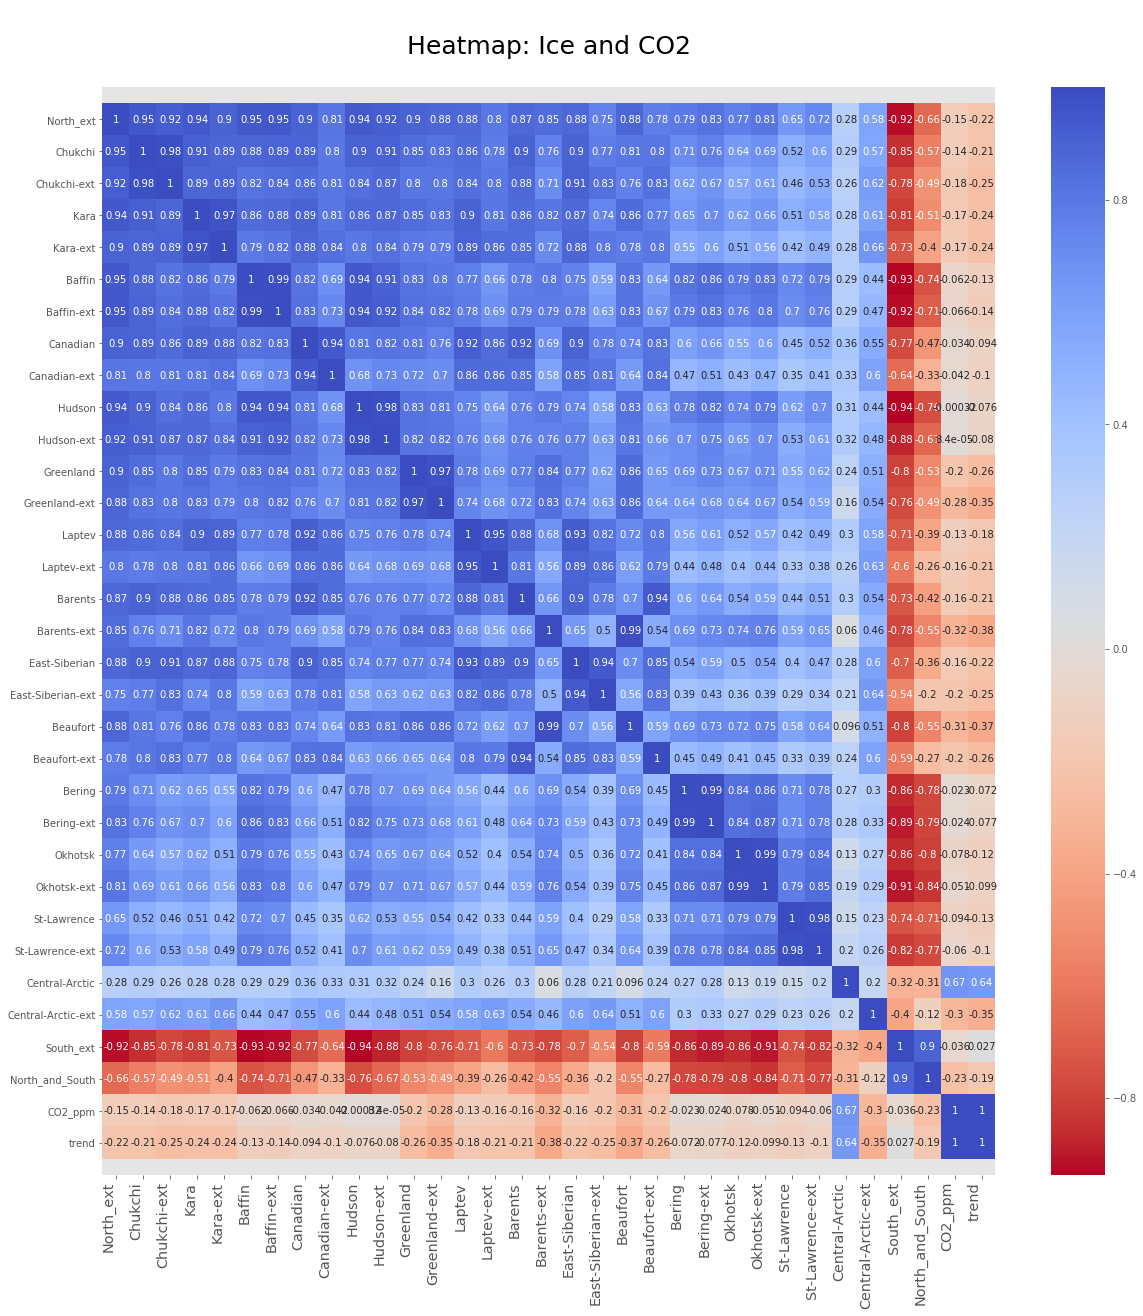

In [124]:
plt.figure(figsize=(20,20))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
ax = sns.heatmap(ice_and_co2.corr(),cmap='coolwarm_r',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('\nHeatmap: Ice and CO2\n', fontsize=25)

The diagram above shows a weak negative correlation between CO2 data and any other column, The exception is between CO2 data and Central Arctic that shows a strong positive correlation. This result will be investigated further in the next stage of this project

EDA - Fire

In [126]:
fire_M6.head(3)

,acq_date,frp,latitude,longitude,decimal_time,mean_brightness,low_confidence,medium_confidence,high_confidence
0,2000-11-01,26.8,-20.8650,146.3039,0.01181,317.00,True,False,False
1,2000-11-01,68.8,-20.5602,146.0194,0.01181,319.95,False,True,False
2,2000-11-01,7.1,-24.3197,151.5619,0.01250,311.15,False,True,False


In [127]:
fire_V1.head(3)

,acq_date,frp,latitude,longitude,decimal_time,mean_brightness,low_confidence,medium_confidence,high_confidence
0,2012-01-31,0.9,11.81456,4.97983,0.05208,298.45,False,True,False
1,2012-01-31,1.3,10.39675,13.45527,0.05208,302.25,False,True,False
2,2012-01-31,1.9,13.73985,13.83765,0.05208,301.80,False,True,False


In [ ]:
import plotly.graph_objects as go
fig = go.Figure(go.Densitymapbox(lat=fire_M6.latitude, lon=fire_M6.longitude, z=fire_M6.frp, radius=4))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()